In [21]:
# Import necessary libraries
import numpy as np
import ast
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.io as pio
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import plotly.graph_objects as go
pio.renderers.default = 'notebook'

In [2]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname="manga_db",
    user="user_master",
    password="PassMaster97",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

In [3]:
# Fetch data from the database
df = pd.read_sql("""
    SELECT DISTINCT ON (mb.original_title)
    mb.id,
    mb.title,
    mb.is_editorial,
    mb.original_title,
    me.embeddings_synopsis_tags,
    me.embeddings_features
    FROM mangas_base mb
    JOIN mangas_embeddings me ON mb.id = me.manga_id
    WHERE me.embeddings_synopsis_tags IS NOT NULL
    AND me.embeddings_features IS NOT NULL
    ORDER BY mb.original_title, mb.is_editorial DESC;
""", conn)

/var/folders/1f/nl9h7sjs4617dm270zv75gq80000gn/T/ipykernel_16971/3596392785.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [4]:
# Function to safely evaluate string representations of lists
def safe_eval(val):
    if pd.isna(val) or val is None:
        return np.array([]) 
    try:
        return np.array(ast.literal_eval(val))
    except Exception as e:
        print(f"❌ Error con valor: {val}\n{e}")
        return np.array([])

# Apply the safe_eval function to the embeddings columns
df["emb_syn_tags_np"] = df["embeddings_synopsis_tags"].apply(safe_eval)
df["emb_features_np"] = df["embeddings_features"].apply(safe_eval)

# Filter the DataFrame to only include rows with non-empty embeddings
df_filtered = df[
    (df["emb_syn_tags_np"].apply(lambda x: x.size > 0)) &
    (df["emb_features_np"].apply(lambda x: x.size > 0))
]


# Convert the embeddings to numpy arrays
X_tags = np.vstack(df_filtered["emb_syn_tags_np"].values)
X_feat = np.vstack(df_filtered["emb_features_np"].values)

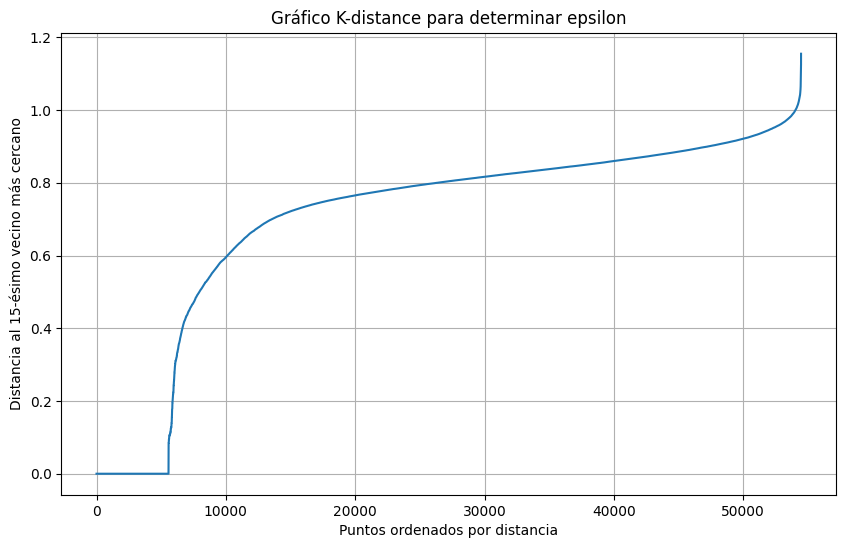

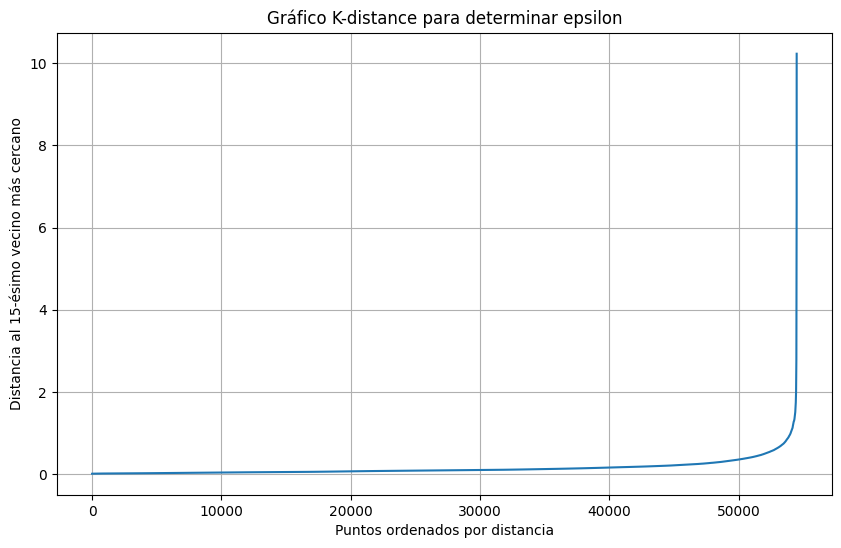

In [9]:
# Función para encontrar el epsilon óptimo usando el método del codo con k-distance
def find_optimal_eps(X, n_neighbors=15):
    # Calcula las distancias a los k vecinos más cercanos
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    
    # Ordena las distancias al k-ésimo vecino más cercano
    k_dist = np.sort(distances[:, -1])
    
    # Grafica la curva de k-distance
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_dist)), k_dist)
    plt.xlabel('Puntos ordenados por distancia')
    plt.ylabel(f'Distancia al {n_neighbors}-ésimo vecino más cercano')
    plt.title('Gráfico K-distance para determinar epsilon')
    plt.grid(True)
    plt.show()
    
    return k_dist

# Encuentra el valor óptimo de epsilon para X_tags
k = min(15, X_tags.shape[1] + 1)  # Dimensión + 1 o 15, el que sea menor
k_distances_tags = find_optimal_eps(X_tags, n_neighbors=k)

# Encuentra el valor óptimo de epsilon para X_feat
k = min(15, X_feat.shape[1] + 1)  # Dimensión + 1 o 15, el que sea menor
k_distances_feat = find_optimal_eps(X_feat, n_neighbors=k)

In [10]:
def evaluate_dbscan_params(X, eps_values, min_samples_values):
    results = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Aplica DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Cuenta el número de clusters (excluyendo ruido que es -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            
            # Porcentaje de puntos considerados como ruido
            noise_percentage = np.sum(labels == -1) / len(labels) * 100
            
            # Calcula silhouette score si hay más de un cluster
            sil_score = np.nan
            if n_clusters > 1 and np.sum(labels != -1) > 1:
                # Solo calcula con puntos no considerados ruido
                non_noise_indices = labels != -1
                if np.sum(non_noise_indices) > 1:
                    sil_score = silhouette_score(X[non_noise_indices], 
                                                 labels[non_noise_indices]) if n_clusters > 1 else np.nan
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_percentage': noise_percentage,
                'silhouette': sil_score
            })
    
    return pd.DataFrame(results)

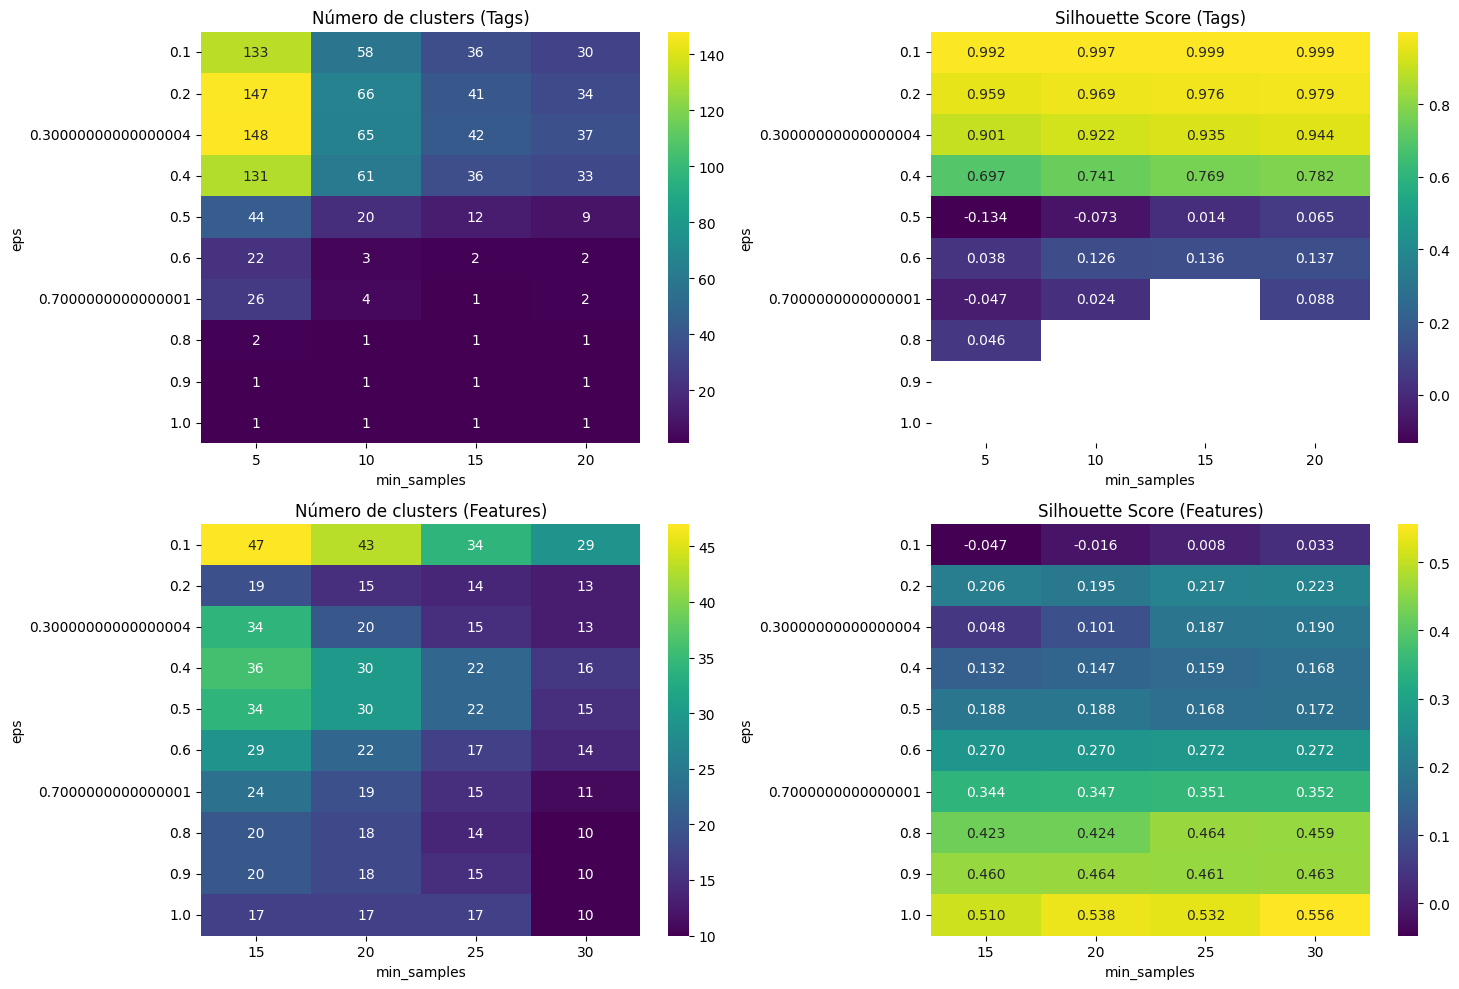

In [11]:
# Basado en la observación del gráfico k-distance, define rangos de epsilon
# Los valores exactos dependerán de lo que observes en el gráfico
eps_values_tags = np.linspace(0.1, 1.0, 10)  # Ajusta según tu gráfico k-distance
eps_values_feat = np.linspace(0.1, 1.0, 10)  # Ajusta según tu gráfico k-distance

# Define rangos de min_samples
# Para tags, usa dimensión + 1 o valores en ese rango
min_samples_tags = [5, 10, 15, 20]  # Ajusta según la dimensión de tus embeddings

# Para features, considera la dimensionalidad (14 + 1 = 15)
min_samples_feat = [15, 20, 25, 30]

# Evalúa combinaciones para tags
results_tags = evaluate_dbscan_params(X_tags, eps_values_tags, min_samples_tags)

# Evalúa combinaciones para features
results_feat = evaluate_dbscan_params(X_feat, eps_values_feat, min_samples_feat)

# Visualiza los resultados
plt.figure(figsize=(15, 10))

# Para tags
plt.subplot(2, 2, 1)
pivot_tags = results_tags.pivot(index='eps', columns='min_samples', values='n_clusters')
sns.heatmap(pivot_tags, annot=True, cmap='viridis', fmt='g')
plt.title('Número de clusters (Tags)')

plt.subplot(2, 2, 2)
pivot_tags = results_tags.pivot(index='eps', columns='min_samples', values='silhouette')
sns.heatmap(pivot_tags, annot=True, cmap='viridis', fmt='.3f')
plt.title('Silhouette Score (Tags)')

# Para features
plt.subplot(2, 2, 3)
pivot_feat = results_feat.pivot(index='eps', columns='min_samples', values='n_clusters')
sns.heatmap(pivot_feat, annot=True, cmap='viridis', fmt='g')
plt.title('Número de clusters (Features)')

plt.subplot(2, 2, 4)
pivot_feat = results_feat.pivot(index='eps', columns='min_samples', values='silhouette')
sns.heatmap(pivot_feat, annot=True, cmap='viridis', fmt='.3f')
plt.title('Silhouette Score (Features)')

plt.tight_layout()
plt.show()

In [12]:
# Encuentra la combinación con mejor silhouette score para tags
best_tags = results_tags.loc[results_tags['silhouette'].idxmax()]
print("Mejores parámetros para Tags:")
print(f"eps = {best_tags['eps']}, min_samples = {best_tags['min_samples']}")
print(f"Número de clusters: {best_tags['n_clusters']}, Silhouette: {best_tags['silhouette']:.4f}")

# Encuentra la combinación con mejor silhouette score para features
best_feat = results_feat.loc[results_feat['silhouette'].idxmax()]
print("\nMejores parámetros para Features:")
print(f"eps = {best_feat['eps']}, min_samples = {best_feat['min_samples']}")
print(f"Número de clusters: {best_feat['n_clusters']}, Silhouette: {best_feat['silhouette']:.4f}")

Mejores parámetros para Tags:
eps = 0.1, min_samples = 20.0
Número de clusters: 30.0, Silhouette: 0.9989

Mejores parámetros para Features:
eps = 1.0, min_samples = 30.0
Número de clusters: 10.0, Silhouette: 0.5559


In [18]:
# Aplica DBSCAN con los mejores parámetros
dbscan_tags = DBSCAN(eps=best_tags['eps'], min_samples=int(best_tags['min_samples']))
dbscan_feat = DBSCAN(eps=best_feat['eps'], min_samples=int(best_feat['min_samples']))

# Obtén los clusters
clusters_tags = dbscan_tags.fit_predict(X_tags)
clusters_feat = dbscan_feat.fit_predict(X_feat)

# Añade los resultados a tu dataframe original
df_filtered['cluster_tags'] = clusters_tags
df_filtered['cluster_features'] = clusters_feat

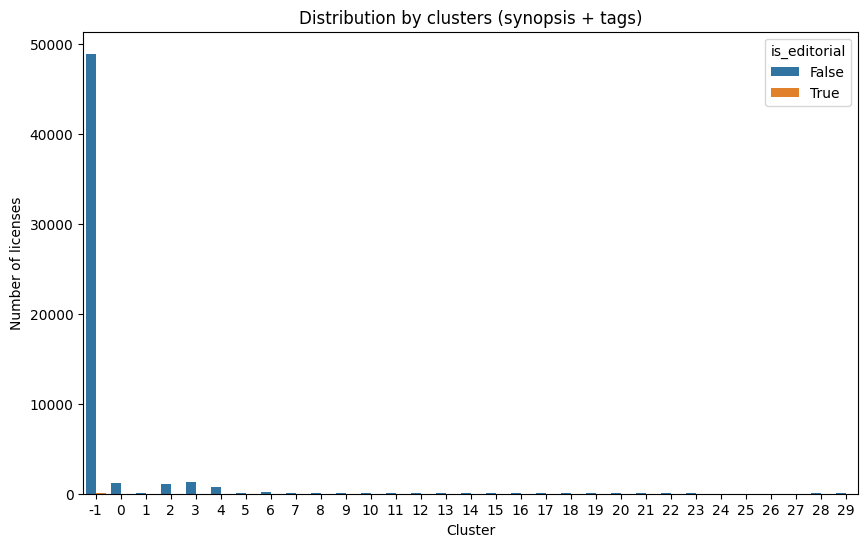

In [19]:
# Agrupate by cluster and is_editorial
cluster_counts = df_filtered.groupby(["cluster_tags", "is_editorial"]).size().reset_index(name="count")

# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_counts, x="cluster_tags", y="count", hue="is_editorial")
plt.title("Distribution by clusters (synopsis + tags)")
plt.xlabel("Cluster")
plt.ylabel("Number of licenses")
plt.show()

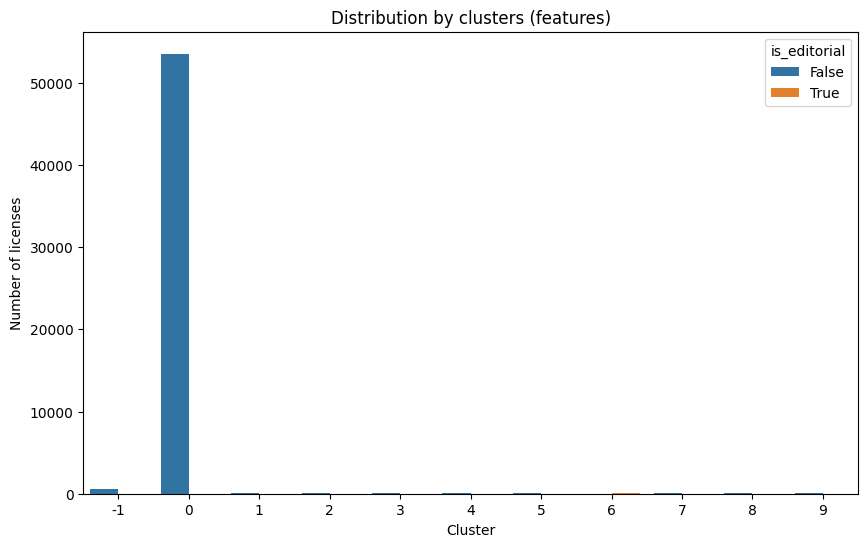

In [20]:
# Agrupate
cluster_counts = df_filtered.groupby(["cluster_features", "is_editorial"]).size().reset_index(name="count")

# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_counts, x="cluster_features", y="count", hue="is_editorial")
plt.title("Distribution by clusters (features)")
plt.xlabel("Cluster")
plt.ylabel("Number of licenses")
plt.show()

SE APLICA UNA REDUCCIÓN DE DIMENSIONALIDAD CON PCA DEBIDO A LA MALDICIÓN DE LA DIMENSIONALIDAD

In [23]:
pca = PCA(n_components=10)
X_tags_reduced = pca.fit_transform(X_tags)
X_feat_reduced = pca.fit_transform(X_feat)

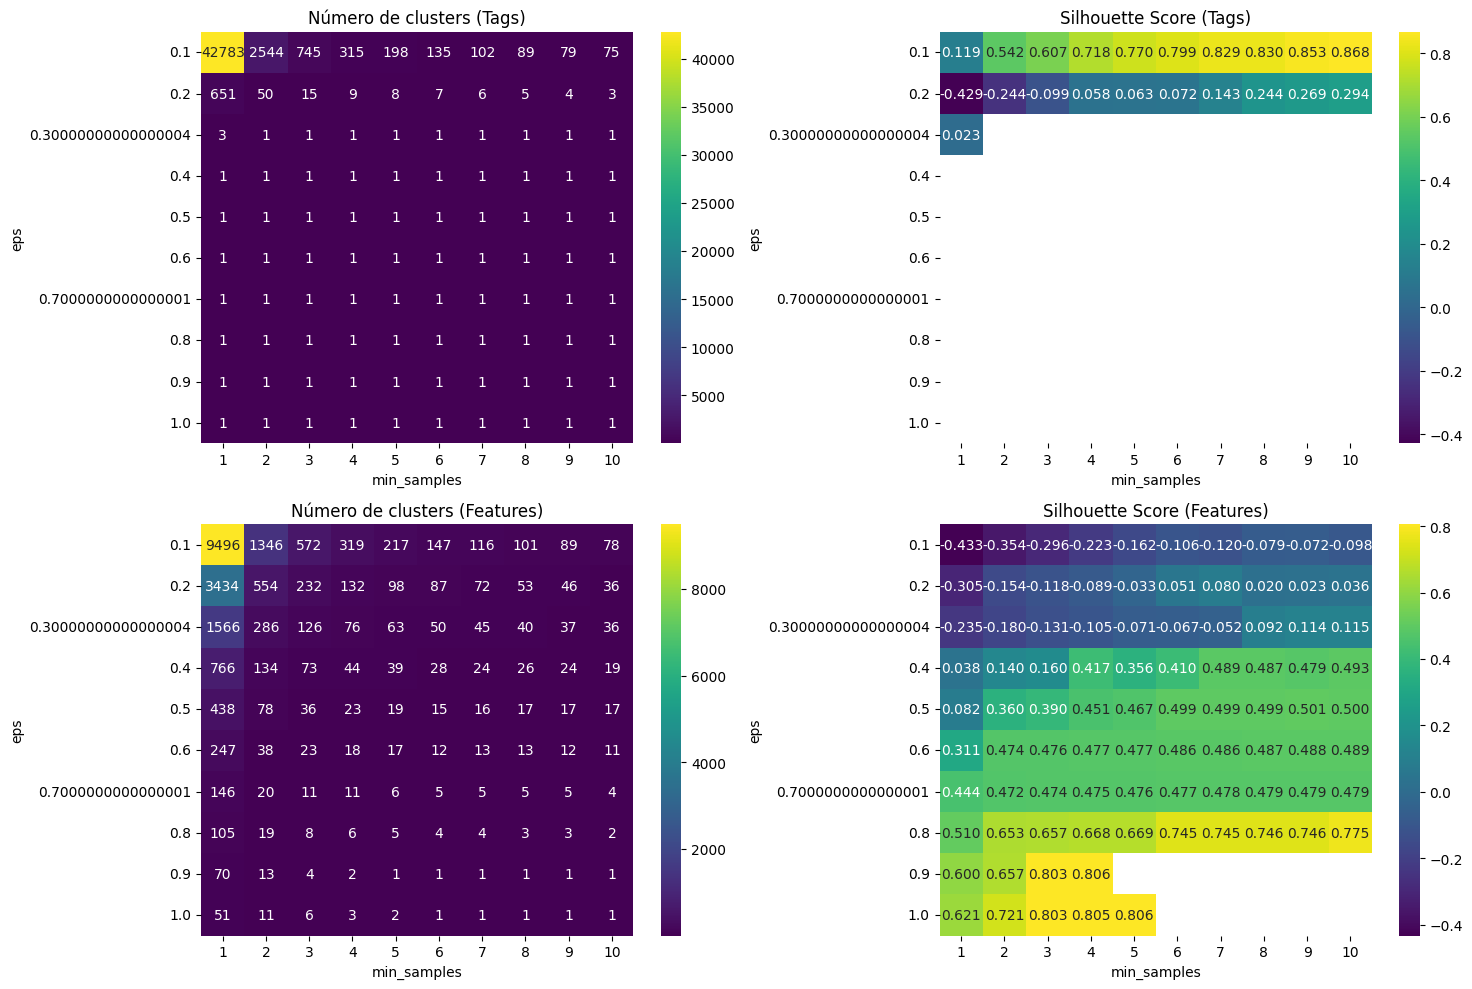

In [25]:
# Basado en la observación del gráfico k-distance, define rangos de epsilon
# Los valores exactos dependerán de lo que observes en el gráfico
eps_values_tags = np.linspace(0.1, 1.0, 10)  # Ajusta según tu gráfico k-distance
eps_values_feat = np.linspace(0.1, 1.0, 10)  # Ajusta según tu gráfico k-distance

# Define rangos de min_samples
# Para tags, usa dimensión + 1 o valores en ese rango
min_samples_tags = list(range(1, 11)) # Ajusta según la dimensión de tus embeddings

# Para features, considera la dimensionalidad (10 + 1 = 11)
min_samples_feat = list(range(1, 11))

# Evalúa combinaciones para tags
results_tags = evaluate_dbscan_params(X_tags_reduced, eps_values_tags, min_samples_tags)

# Evalúa combinaciones para features
results_feat = evaluate_dbscan_params(X_feat_reduced, eps_values_feat, min_samples_feat)

# Visualiza los resultados
plt.figure(figsize=(15, 10))

# Para tags
plt.subplot(2, 2, 1)
pivot_tags = results_tags.pivot(index='eps', columns='min_samples', values='n_clusters')
sns.heatmap(pivot_tags, annot=True, cmap='viridis', fmt='g')
plt.title('Número de clusters (Tags)')

plt.subplot(2, 2, 2)
pivot_tags = results_tags.pivot(index='eps', columns='min_samples', values='silhouette')
sns.heatmap(pivot_tags, annot=True, cmap='viridis', fmt='.3f')
plt.title('Silhouette Score (Tags)')

# Para features
plt.subplot(2, 2, 3)
pivot_feat = results_feat.pivot(index='eps', columns='min_samples', values='n_clusters')
sns.heatmap(pivot_feat, annot=True, cmap='viridis', fmt='g')
plt.title('Número de clusters (Features)')

plt.subplot(2, 2, 4)
pivot_feat = results_feat.pivot(index='eps', columns='min_samples', values='silhouette')
sns.heatmap(pivot_feat, annot=True, cmap='viridis', fmt='.3f')
plt.title('Silhouette Score (Features)')

plt.tight_layout()
plt.show()

In [26]:
# Encuentra la combinación con mejor silhouette score para tags
best_tags = results_tags.loc[results_tags['silhouette'].idxmax()]
print("Mejores parámetros para Tags:")
print(f"eps = {best_tags['eps']}, min_samples = {best_tags['min_samples']}")
print(f"Número de clusters: {best_tags['n_clusters']}, Silhouette: {best_tags['silhouette']:.4f}")

# Encuentra la combinación con mejor silhouette score para features
best_feat = results_feat.loc[results_feat['silhouette'].idxmax()]
print("\nMejores parámetros para Features:")
print(f"eps = {best_feat['eps']}, min_samples = {best_feat['min_samples']}")
print(f"Número de clusters: {best_feat['n_clusters']}, Silhouette: {best_feat['silhouette']:.4f}")

Mejores parámetros para Tags:
eps = 0.1, min_samples = 10.0
Número de clusters: 75.0, Silhouette: 0.8677

Mejores parámetros para Features:
eps = 0.9, min_samples = 4.0
Número de clusters: 2.0, Silhouette: 0.8060


----------------------------------------------------------------------------------------------------------------

In [33]:
# Aplica DBSCAN con los mejores parámetros
dbscan_tags = DBSCAN(eps=best_tags['eps'], min_samples=int(best_tags['min_samples']))
dbscan_feat = DBSCAN(eps=best_feat['eps'], min_samples=int(best_feat['min_samples']))

# Obtén los clusters
clusters_tags = dbscan_tags.fit_predict(X_tags)
clusters_feat = dbscan_feat.fit_predict(X_feat)

# Añade los resultados a tu dataframe original
df_filtered['cluster_tags'] = clusters_tags
df_filtered['cluster_features'] = clusters_feat

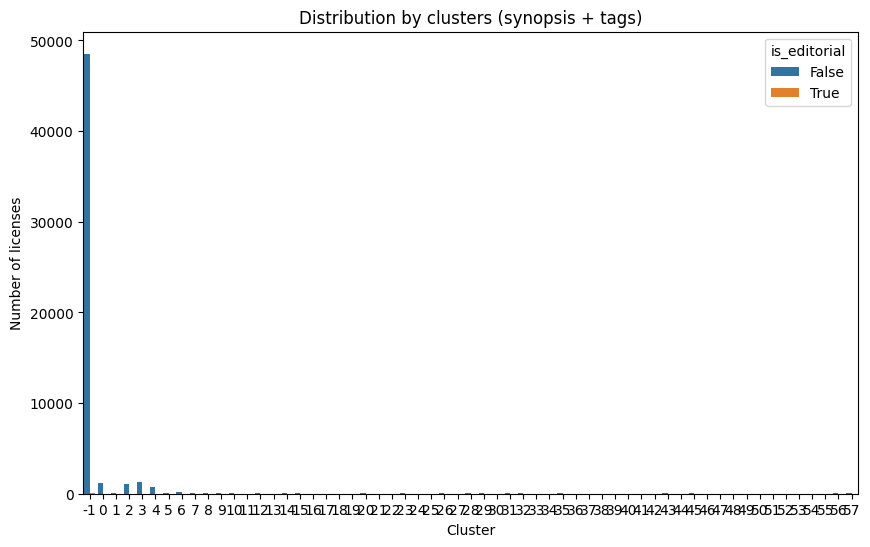

In [34]:
# Agrupate by cluster and is_editorial
cluster_counts = df_filtered.groupby(["cluster_tags", "is_editorial"]).size().reset_index(name="count")

# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_counts, x="cluster_tags", y="count", hue="is_editorial")
plt.title("Distribution by clusters (synopsis + tags)")
plt.xlabel("Cluster")
plt.ylabel("Number of licenses")
plt.show()

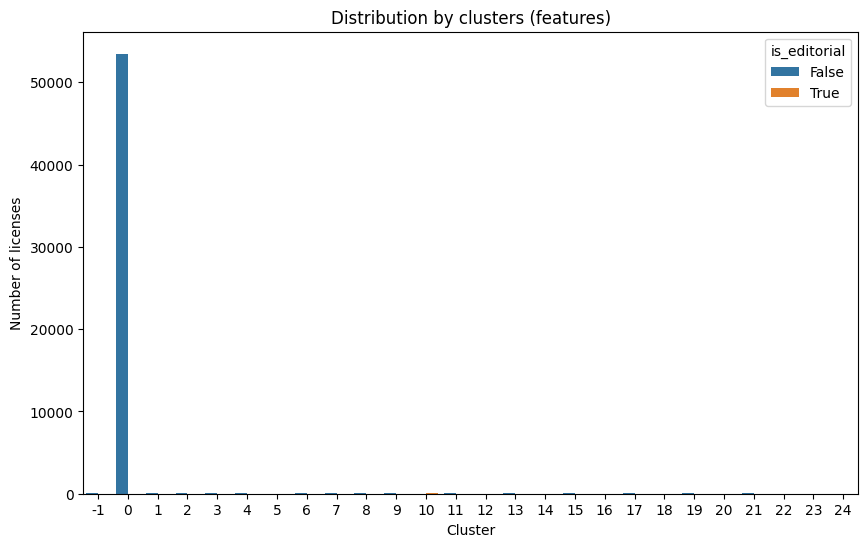

In [35]:
# Agrupate
cluster_counts = df_filtered.groupby(["cluster_features", "is_editorial"]).size().reset_index(name="count")

# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_counts, x="cluster_features", y="count", hue="is_editorial")
plt.title("Distribution by clusters (features)")
plt.xlabel("Cluster")
plt.ylabel("Number of licenses")
plt.show()

-------------------------------------------------------------------------------------------------------------------------

In [34]:
# Select editorial and non-editorial DataFrames
df_editorial = df_filtered[df_filtered["is_editorial"] == True]
df_otros = df_filtered[df_filtered["is_editorial"] == False]

# Convert the editorial and non-editorial embeddings to numpy arrays
X_editorial = np.vstack(df_editorial["emb_features_np"].values)
X_otros = np.vstack(df_otros["emb_features_np"].values)

# Get the indices of the editorial and non-editorial DataFrames
idx_editorial = df_editorial.index
idx_otros = df_otros.index

In [35]:
# Select editorial and non-editorial DataFrames
df_editorial = df_filtered[df_filtered["is_editorial"] == True]
df_otros = df_filtered[df_filtered["is_editorial"] == False]

# Convert the editorial and non-editorial embeddings to numpy arrays of synopsis + tags
X_editorial_syn_tags = np.vstack(df_editorial["emb_syn_tags_np"].values)
X_otros_syn_tags = np.vstack(df_otros["emb_syn_tags_np"].values)

In [36]:
sim_matrix_feat = cosine_similarity(X_editorial, X_otros)

In [37]:
sim_matrix_syn_tags = cosine_similarity(X_editorial_syn_tags, X_otros_syn_tags)

In [38]:
# Get the top N most similar non-editorial works for each editorial work
top_n = 10
tabla_similares = []

for i in range(len(df_editorial)):
    nombre_editorial = df_editorial.iloc[i]["title"]
    id_editorial = df_editorial.iloc[i]["id"]
    
    # Index of the most similar works
    top_sim_idx = sim_matrix_feat[i].argsort()[::-1][:top_n]
    similares = df_otros.iloc[top_sim_idx]
    
    fila = {"Obra Editorial": nombre_editorial, "ID Editorial": id_editorial}
    
    for j, (_, sim_row) in enumerate(similares.iterrows(), 1):
        fila[f"Similar {j}"] = sim_row["title"]
        fila[f"ID {j}"] = sim_row["id"]
    
    tabla_similares.append(fila)

# Convert the list of dictionaries to a DataFrame
df_similares_tabla = pd.DataFrame(tabla_similares)

# Show
df_similares_tabla.head(50)

Obra Editorial  ID Editorial  \
0                        7000 millones de agujas           197   
1                            CANIS -Dear Hatter-           224   
2                                           MADK           231   
3                                         Q [KÛ]           213   
4                            El bebé de mi novia           202   
5                                        Imakako           206   
6               ¡Huyamos juntas! (Kakeochi Girl)           242   
7                                   Padre e hijo           212   
8                                      Yajirobee           221   
9                                         X-Gene           220   
10                                           EAT           226   
11                                       Wallman           219   
12                Make the exorcist fall in love           209   
13                                   On Doorstep           233   
14                                      Gangsta.           204   
15                                         Given           227   
16                                 Saturn Return           215   
17                                      Jealousy           229   
18                                        Cherry           200   
19                                     Tail Star           216   
20                      Happiness (Shûzô Oshimi)           205   
21                                      Badducks           199   
22                                   Barbarities           223   
23                                    Filamentos           203   
24                        Versailles of the Dead           218   
25                  Restart After Come Back Home           236   
26                                    Scramblues           237   
27                    You are in the blue summer           240   
28                        Afterimage Slow Motion           222   
29                                 Ocean Endroll           211   
30                                Mangaka Nyûmon           245   
31  Perros en la ciudad de la nieve color ceniza           234   
32                                      Tamayura           238   
33                             Kamisama no Joker           207   
34            Una sonrisa hasta el fin del mundo           217   
35                                A Silent Voice           198   
36                         La herencia del aroma           230   
37              Nijigahara Holograph (Milky Way)           210   
38                             Rastros de Sangre           214   
39               Home Far Away (Un hogar lejano)           228   
40                  Nagahama To Be, or Not To Be           232   
41                                    Disonancia           225   
42                          Qualia bajo la nieve           235   
43                                 Flores Azules           241   
44            La Balada del Viento y los Árboles           208   
45                      Un demonio en el paraíso           239   
46                              Killing Stalking           243   

                                           Similar 1    ID 1  \
0                                   Mister no Kotori   87049   
1                                               home   65804   
2   Ore to Joushi no Kakushigoto: Tsuzuki no Hanashi   63793   
3                                   Mister no Kotori   87049   
4                                 Isekai Goumon Hime   74129   
5                             Death House: Shi no Ie   85974   
6                                            TEMPEST   73527   
7                   Lord El-Melloi II-sei no Jikenbo   75132   
8                                        Hensoukyoku   54038   
9                                       Sunroom nite   59895   
10                                            behind   83237   
11                           Manatsu no Yoru no Yume   87096   
12                               

In [39]:
# Get the top N most similar non-editorial works for each editorial work
top_n = 10
tabla_similares_sin_tags = []

for i in range(len(df_editorial)):
    nombre_editorial = df_editorial.iloc[i]["title"]
    id_editorial = df_editorial.iloc[i]["id"]
    
    # Index of the most similar works
    top_sim_idx = sim_matrix_syn_tags[i].argsort()[::-1][:top_n]
    similares = df_otros.iloc[top_sim_idx]
    
    fila = {"Obra Editorial": nombre_editorial, "ID Editorial": id_editorial}
    
    for j, (_, sim_row) in enumerate(similares.iterrows(), 1):
        fila[f"Similar {j}"] = sim_row["title"]
        fila[f"ID {j}"] = sim_row["id"]
    
    tabla_similares_sin_tags.append(fila)

# Convert the list of dictionaries to a DataFrame
df_similares_tabla_syn_tags = pd.DataFrame(tabla_similares_sin_tags)

# Show
df_similares_tabla_syn_tags.head(50)

Obra Editorial  ID Editorial  \
0                        7000 millones de agujas           197   
1                            CANIS -Dear Hatter-           224   
2                                           MADK           231   
3                                         Q [KÛ]           213   
4                            El bebé de mi novia           202   
5                                        Imakako           206   
6               ¡Huyamos juntas! (Kakeochi Girl)           242   
7                                   Padre e hijo           212   
8                                      Yajirobee           221   
9                                         X-Gene           220   
10                                           EAT           226   
11                                       Wallman           219   
12                Make the exorcist fall in love           209   
13                                   On Doorstep           233   
14                                      Gangsta.           204   
15                                         Given           227   
16                                 Saturn Return           215   
17                                      Jealousy           229   
18                                        Cherry           200   
19                                     Tail Star           216   
20                      Happiness (Shûzô Oshimi)           205   
21                                      Badducks           199   
22                                   Barbarities           223   
23                                    Filamentos           203   
24                        Versailles of the Dead           218   
25                  Restart After Come Back Home           236   
26                                    Scramblues           237   
27                    You are in the blue summer           240   
28                        Afterimage Slow Motion           222   
29                                 Ocean Endroll           211   
30                                Mangaka Nyûmon           245   
31  Perros en la ciudad de la nieve color ceniza           234   
32                                      Tamayura           238   
33                             Kamisama no Joker           207   
34            Una sonrisa hasta el fin del mundo           217   
35                                A Silent Voice           198   
36                         La herencia del aroma           230   
37              Nijigahara Holograph (Milky Way)           210   
38                             Rastros de Sangre           214   
39               Home Far Away (Un hogar lejano)           228   
40                  Nagahama To Be, or Not To Be           232   
41                                    Disonancia           225   
42                          Qualia bajo la nieve           235   
43                                 Flores Azules           241   
44            La Balada del Viento y los Árboles           208   
45                      Un demonio en el paraíso           239   
46                              Killing Stalking           243   

                                            Similar 1    ID 1  \
0                                      70 Oku no Hari   69416   
1                                  Canis: Dear Hatter   60543   
2                                            Devilman   67672   
3                                               Sarai   92856   
4         Tonari no Seki no Ichinose-kun wa iimashita   92076   
5                             Extracurricular Lessons   78661   
6                          Koi to Yobu ni wa Aosugiru  103684   
7                  Tooda Oto Tanhenshuu: Niku wo Hagu   97301   
8                                       A Small World   83447   
9                                   Aoi Haru, Kai Ito   58815   
10                                                EAT   65440   
11                                         Shutendoji   99180   
12                  

In [40]:
# Build a dictionary with the most similar works for each editorial work based on features
similares_por_obra_feat = {}
for i, idx in enumerate(df_editorial.index):
    # Get index of the most similar works
    top_sim_idx = sim_matrix_feat[i].argsort()[::-1][:top_n]
    
    # select the most similar works
    similares = df_otros.iloc[top_sim_idx][["id", "title"]]
    similares_por_obra_feat[df_editorial.loc[idx, "title"]] = similares

In [41]:
# Build a dictionary with the most similar works for each editorial work based on synopsis + tags
similares_por_obra_syn_tags = {}
for i, idx in enumerate(df_editorial.index):
    # Get index of the most similar works
    top_sim_idx = sim_matrix_syn_tags[i].argsort()[::-1][:top_n]
    # Get the most similar works
    similares = df_otros.iloc[top_sim_idx][["id", "title"]]
    similares_por_obra_syn_tags[df_editorial.loc[idx, "title"]] = similares

In [ ]:
# For tsne, we need to convert the features to 3D
X_feat = np.vstack(df_filtered["emb_features_np"].values)
# Reduce the dimensionality to 3D
X_3d = TSNE(n_components=3, random_state=42).fit_transform(X_feat)

# Add the 3D coordinates to the DataFrame
df_filtered_features = df_filtered.reset_index(drop=True)  # por si acaso
df_filtered_features["x"] = X_3d[:, 0]
df_filtered_features["y"] = X_3d[:, 1]
df_filtered_features["z"] = X_3d[:, 2]

# Initialize the "tipo" column
df_filtered_features["tipo"] = "otros"

# Check if the work is editorial
df_filtered_features.loc[df_filtered_features["is_editorial"] == True, "tipo"] = "editorial"

# Get the IDs of the similar works
ids_similares = set()
for sim_df in similares_por_obra_feat.values():
    ids_similares.update(sim_df["id"].tolist())

# Check if the work is similar
df_filtered_features["tipo"] = df_filtered_features.apply(
    lambda row: "similar" if (row["id"] in ids_similares and row["tipo"] != "editorial") else row["tipo"],
    axis=1
)


# -------------------------------

# 1. Map symbols, sizes, and opacities
symbol_map = {
    "editorial": "diamond",
    "similar": "cross",
    "otros": "circle"
}

size_map = {
    "editorial": 10,
    "similar": 8,
    "otros": 3
}

opacity_map = {
    "editorial": 1.0,
    "similar": 0.8,
    "otros": 0.2
}

df_filtered_features["symbol"] = df_filtered_features["tipo"].map(symbol_map)
df_filtered_features["size"] = df_filtered_features["tipo"].map(size_map)
df_filtered_features["opacity"] = df_filtered_features["tipo"].map(opacity_map)

# 2. Plot
fig = px.scatter_3d(
    df_filtered_features,
    x="x", y="y", z="z",
    color="cluster_features",  # o "cluster_tags"
    symbol="tipo",
    size="size",
    opacity=0.8,  # Esta controla la capa global de opacidad (dejamos 0.8 y usamos la individual también abajo)
    hover_data=["title", "id", "tipo"],
    title="Obras de manga en 3D: clustering + relación editorial"
)

# 3. Update the traces with the custom opacity
for trace in fig.data:
    tipo = trace.name
    trace.opacity = opacity_map.get(tipo, 0.4)

fig.update_traces(marker=dict(line=dict(width=0)))  # Remove the border
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['id', 'title', 'is_editorial', 'original_title', 'embeddings_synopsis_tags', 'embeddings_features', 'emb_syn_tags_np', 'emb_features_np', 'cluster_tags', 'cluster_features'] but received: x

In [ ]:

X_tags = np.vstack(df_filtered["emb_syn_tags_np"].values)
# Reduce the dimensionality to 3D
X_3d = TSNE(n_components=3, random_state=42).fit_transform(X_tags)

# Add the 3D coordinates to the DataFrame
df_filtered_syn_tags = df_filtered.reset_index(drop=True)  # por si acaso
df_filtered_syn_tags["x"] = X_3d[:, 0]
df_filtered_syn_tags["y"] = X_3d[:, 1]
df_filtered_syn_tags["z"] = X_3d[:, 2]

# Initialize the "tipo" column
df_filtered_syn_tags["tipo"] = "otros"

# Check if the work is editorial
df_filtered_syn_tags.loc[df_filtered_syn_tags["is_editorial"] == True, "tipo"] = "editorial"

# Get IDs of the similar works
ids_similares = set()
for sim_df in similares_por_obra_syn_tags.values():
    ids_similares.update(sim_df["id"].tolist())

# Check if the work is similar
df_filtered_syn_tags["tipo"] = df_filtered_syn_tags.apply(
    lambda row: "similar" if (row["id"] in ids_similares and row["tipo"] != "editorial") else row["tipo"],
    axis=1
)


# 1. Assign symbols, sizes, and opacities
symbol_map = {
    "editorial": "diamond",
    "similar": "cross",
    "otros": "circle"
}

size_map = {
    "editorial": 8,
    "similar": 6,
    "otros": 3
}

opacity_map = {
    "editorial": 1.0,
    "similar": 0.9,
    "otros": 0.4
}

df_filtered_syn_tags["symbol"] = df_filtered_syn_tags["tipo"].map(symbol_map)
df_filtered_syn_tags["size"] = df_filtered_syn_tags["tipo"].map(size_map)
df_filtered_syn_tags["opacity"] = df_filtered_syn_tags["tipo"].map(opacity_map)

# 2. Plot
fig = px.scatter_3d(
    df_filtered_syn_tags,
    x="x", y="y", z="z",
    color="cluster_tags",  # o "cluster_tags"
    symbol="tipo",
    size="size",
    opacity=0.8,  # Esta controla la capa global de opacidad (dejamos 0.8 y usamos la individual también abajo)
    hover_data=["title", "id", "tipo"],
    title="Obras de manga en 3D: clustering + relación editorial"
)

# 3. Update the traces with the custom opacity
for trace in fig.data:
    tipo = trace.name
    trace.opacity = opacity_map.get(tipo, 0.4)

fig.update_traces(marker=dict(line=dict(width=0)))  # Remove the border
fig.show()

In [ ]:
# Group by cluster_tags and tipo
tabla_tags = df_filtered.groupby(["cluster_tags", "tipo"]).size().unstack(fill_value=0)

# Group by cluster_features and tipo
tabla_features = df_filtered.groupby(["cluster_features", "tipo"]).size().unstack(fill_value=0)

# show the tables
print("📘 Grouping by cluster_tags (sinopsis + tags):")
display(tabla_tags)

print("\n📗 Grouping by cluster_features:")
display(tabla_features)

📘 Grouping by cluster_tags (sinopsis + tags):


tipo          editorial  otros  similar
cluster_tags                           
0                    11   6397       44
1                     0   1681        0
2                     1   4016       14
3                     3   3886       15
4                     0   2355       16
5                    13   6985       25
6                     1   2814       20
7                     8   6760       27
8                     0   2995        8
9                     5   4597        6
10                    0   2299        1
11                    1   3618       30
12                    4   5798       20


📗 Grouping by cluster_features:


tipo              editorial  otros  similar
cluster_features                           
0                         9   7996       30
1                         0  30307       32
2                        18   5569      111
3                        20   1533       48
4                         0   8796        5

In [ ]:
# ------------------------------
# 1. PURITY OF CLUSTERS
# ------------------------------
def calcular_pureza(df, cluster_col):
    total_samples = len(df)
    pureza_total = 0

    for cluster_id, grupo in df.groupby(cluster_col):
        cuenta_tipos = grupo["tipo"].value_counts()
        maximo = cuenta_tipos.max()
        pureza_cluster = maximo / len(grupo)
        pureza_total += maximo

        print(f"Cluster {cluster_id} ({len(grupo)} works): purity = {pureza_cluster:.2f} | composition = {cuenta_tipos.to_dict()}")

    pureza_global = pureza_total / total_samples
    print(f"\n🔎 Global purity ({cluster_col}): {pureza_global:.2f}")
    return pureza_global

print("\n🔷 PURITY - cluster_tags")
pureza_tags = calcular_pureza(df_filtered, "cluster_tags")

print("\n🔶 PURITY - cluster_features")
pureza_features = calcular_pureza(df_filtered, "cluster_features")


# ------------------------------
# 2. CONTINGENCY MATRIX 
# ------------------------------
print("\n🧮 CONTINGENCY MATRIX (cluster_tags vs cluster_features)")
matriz_contingencia = pd.crosstab(df_filtered["cluster_tags"], df_filtered["cluster_features"])
display(matriz_contingencia)


🔷 PURITY - cluster_tags
Cluster 0 (6452 works): purity = 0.99 | composition = {'otros': 6397, 'similar': 44, 'editorial': 11}
Cluster 1 (1681 works): purity = 1.00 | composition = {'otros': 1681}
Cluster 2 (4031 works): purity = 1.00 | composition = {'otros': 4016, 'similar': 14, 'editorial': 1}
Cluster 3 (3904 works): purity = 1.00 | composition = {'otros': 3886, 'similar': 15, 'editorial': 3}
Cluster 4 (2371 works): purity = 0.99 | composition = {'otros': 2355, 'similar': 16}
Cluster 5 (7023 works): purity = 0.99 | composition = {'otros': 6985, 'similar': 25, 'editorial': 13}
Cluster 6 (2835 works): purity = 0.99 | composition = {'otros': 2814, 'similar': 20, 'editorial': 1}
Cluster 7 (6795 works): purity = 0.99 | composition = {'otros': 6760, 'similar': 27, 'editorial': 8}
Cluster 8 (3003 works): purity = 1.00 | composition = {'otros': 2995, 'similar': 8}
Cluster 9 (4608 works): purity = 1.00 | composition = {'otros': 4597, 'similar': 6, 'editorial': 5}
Cluster 10 (2300 works): pur

cluster_features     0     1     2    3     4
cluster_tags                                 
0                  988  2920  1149  368  1027
1                  217  1335   100   25     4
2                  639  2491   599  150   152
3                  404  1187   514   99  1700
4                  466  1591   196   88    30
5                  812  5526   386   62   237
6                  672  1859    81  118   105
7                 1157  4298  1015  167   158
8                  555  2161   213   61    13
9                  293   370   387   93  3465
10                 295  1323    81   24   577
11                 714  2340   383  170    42
12                 823  2938   594  176  1291